In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [16]:
image = cv2.imread(r"/home/miekale/Documents/github/ArticusMaximus/python_edge_detection/sample_images/amogus.png")
image = cv2.resize(image, (int(image.shape[1]/2), int(image.shape[0]/2)), interpolation=cv2.INTER_AREA)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [17]:
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
# Threshold
ret, thresh = cv2.threshold(gray, 100, 225, cv2.THRESH_BINARY)
cv2.imshow("threshold", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
# Blur 
blur = cv2.GaussianBlur(gray, (5,5), sigmaX=0, sigmaY=0)
cv2.imshow("blur", blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
# Canny
canny = cv2.Canny(gray, 30, 200)
cv2.imshow("Canny", canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
# Canny w blur
canny_blur = cv2.Canny(blur, 30, 200)
cv2.imshow("Canny w blur", canny_blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

0 and 1: 0.00039239307983012086
437.3954314720812 and 438.0025536261491
1 and 2: 0.6061789467799367
438.0025536261491 and 333.67660550458714
2 and 3: 0.0015021299583768148
333.67660550458714 and 334.7056074766355
3 and 4: 0.5474630376822837
334.7056074766355 and 440.425
4 and 5: 0.004578940800828187
440.425 and 440.626582278481
5 and 6: 4.246829980413695
440.626582278481 and 444.2541928721174
6 and 7: 1.8768451112224696
444.2541928721174 and 446.45194508009155
7 and 8: 0.0008254854426183113
446.45194508009155 and 447.55466052934406


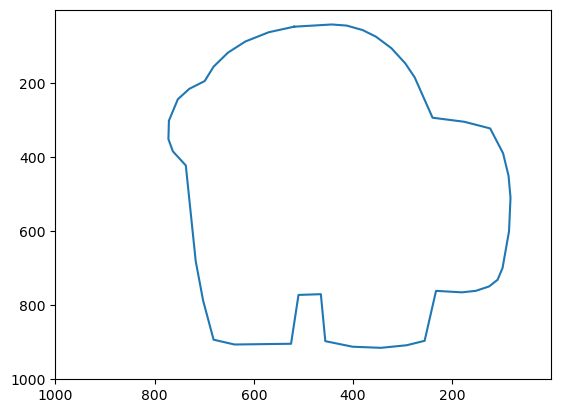

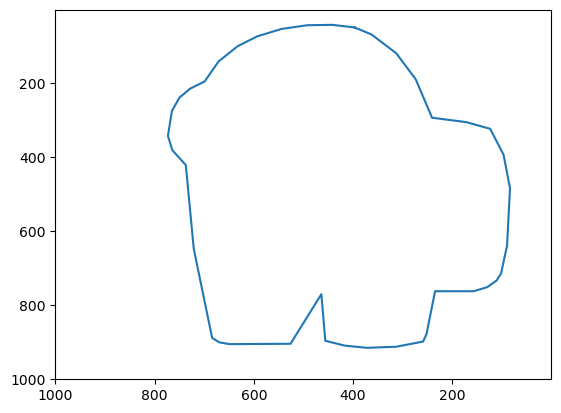

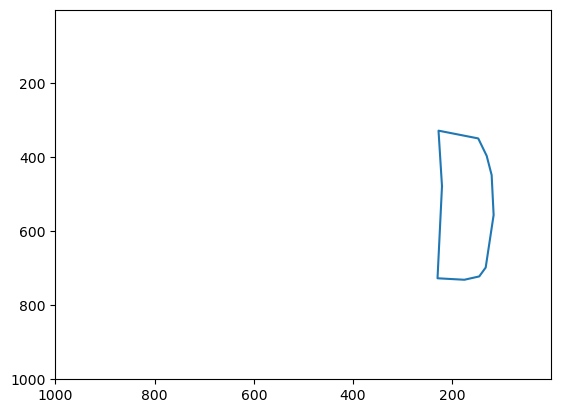

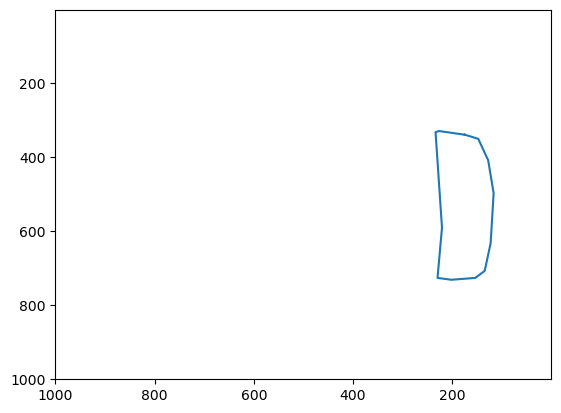

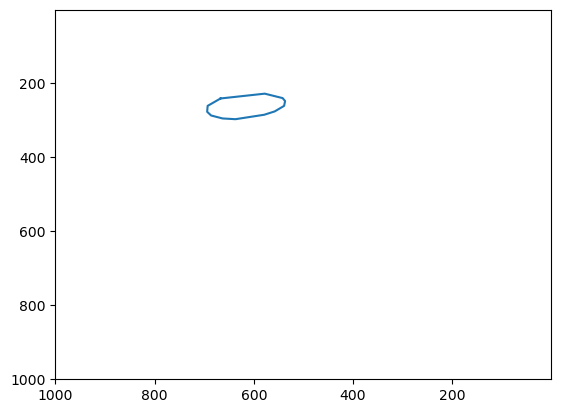

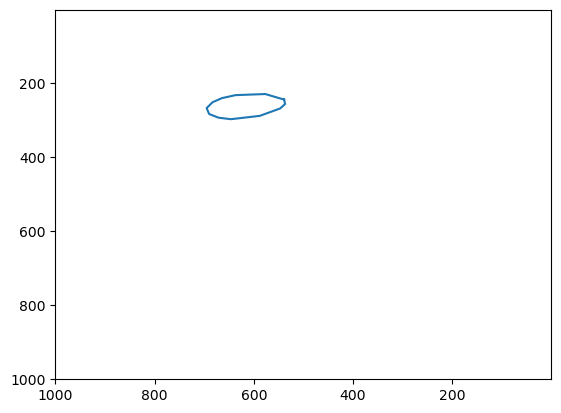

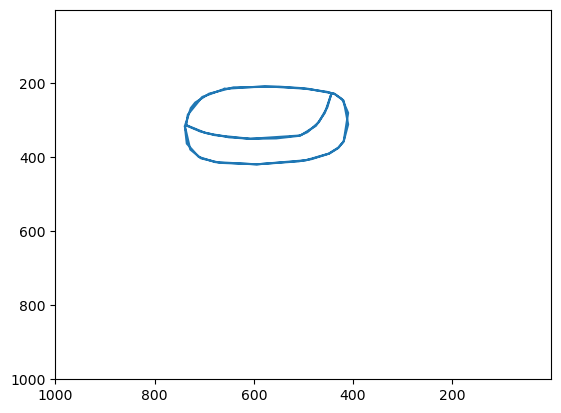

/tmp/ipykernel_3002/997667857.py:8: RuntimeWarning: invalid value encountered in scalar divide
  proj_u_on_v = np.array([np.dot(vectoru, vectorv) / v_norm**2 * vectorv[0], np.dot(vectoru, vectorv) / v_norm**2 * vectorv[1]])


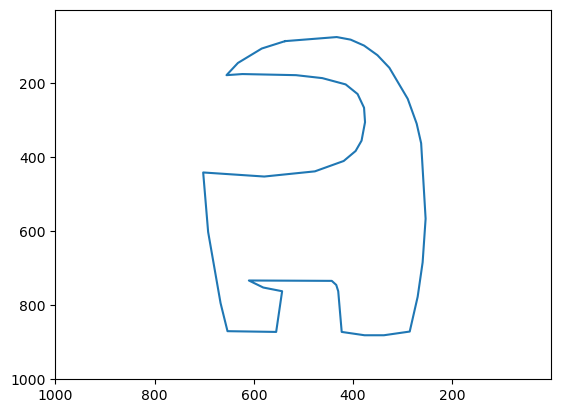

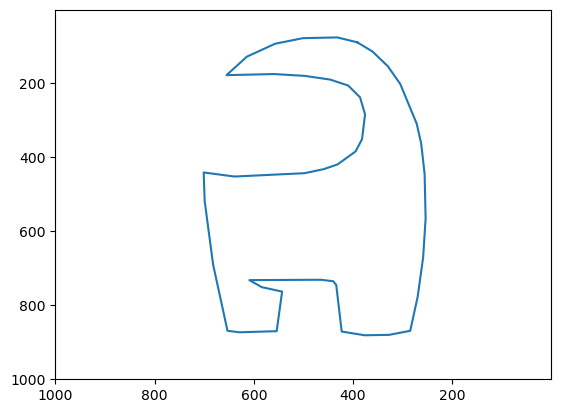

In [37]:
def perp_distance(pstart, pend, point):

    vectoru = np.array([point[0] - pstart[0], point[1] - pstart[1]])
    vectorv = np.array([pend[0] - pstart[0], pend[1] - pstart[1]])

    #finding  projection vector
    v_norm = np.sqrt(vectorv[0]**2 + vectorv[1]**2)
    proj_u_on_v = np.array([np.dot(vectoru, vectorv) / v_norm**2 * vectorv[0], np.dot(vectoru, vectorv) / v_norm**2 * vectorv[1]])

    #finding perpendicular vector
    perp_u_on_v = np.array([vectoru[0] - proj_u_on_v[0], vectoru[1] - proj_u_on_v[1]])

    return np.sqrt(perp_u_on_v[0]**2 + perp_u_on_v[1]**2)


def Douglas_Peucker(points, epsilon):
    #max distance and index of the distance
    dmax = 0
    index = 0

    #for all points find distance and set dmax if largest
    for i, value in enumerate(points):
        distance = perp_distance(points[0], points[len(points)-1], points[i])
        if distance > dmax:
            dmax = distance
            index = i
    result_list = np.array([])

    #recursive algorithm
    if (dmax > epsilon):
        upper_recursive = Douglas_Peucker(points[0:index], epsilon)
        lower_recursive = Douglas_Peucker(points[index:len(points)], epsilon)
        
        #build resulting list
        result_list = np.concatenate((lower_recursive[0:(len(lower_recursive) - 1)], upper_recursive[0:len(upper_recursive - 1)]), axis=0)
    else:
        result_list = np.array([points[0], points[len(points)-1]])

    # return value
    return result_list
    

epsilon = 3

contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

num_contours = len(contours)

def remove_duplicate_contours(contours, match_thresh, pixel_thresh):
    num_contours = len(contours)
    # Checking contour pairs
    for i in range(num_contours -1 ):
        match_score = cv2.matchShapes(contours[i], contours[i+1], cv2.CONTOURS_MATCH_I3,0)
        # Remove contours with same shape in same location
        if match_score < match_thresh:
            mean_1 = contours[i].mean()
            mean_2 = contours[i+1].mean()
            if (abs(mean_1 - mean_2) < pixel_thresh):
                contours = np.delete(contours, i)

            


        print(f'{ i } and {i + 1}: {cv2.matchShapes(contours[i], contours[i+1], cv2.CONTOURS_MATCH_I3,0)}')
        print(f'{contours[i].mean()} and {contours[i+1].mean()}')


for i in range(num_contours):
    plt.xlim(1000)
    plt.ylim(1000)
    contour_img = contours[i]
    if contour_img.shape[0] != 1:
        contour_img = np.squeeze(contour_img)
        contour_img = Douglas_Peucker(contour_img, epsilon)
        contour_img[-1] = contour_img[0]
        plt.plot(contour_img[:,0], contour_img[:,1], label=f'{i}')
    plt.show()


In [23]:
a = np.array([[[1,2], [4,5]], ])
a = np.squeeze(a)
a = np.concatenate((a, np.expand_dims(a[0], axis=0)))
a

array([[1, 2],
       [4, 5],
       [1, 2]])

In [24]:
b = np.array([[1,2], [4,5]])
b.shape

(2, 2)

1


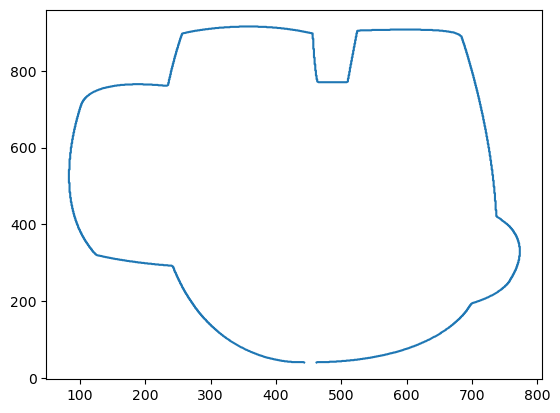

9


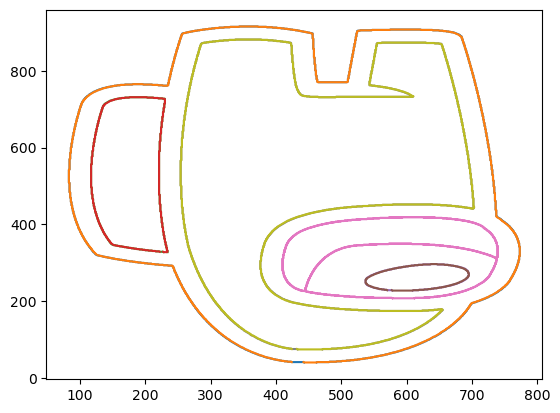

9


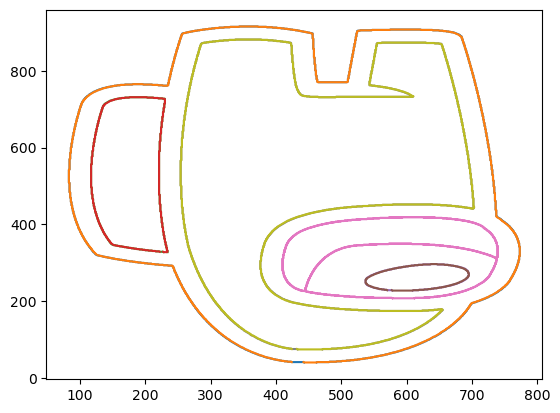

In [25]:
# All contours
# Contour detection
contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

num_contours = len(contours)
print(num_contours)
for i in range(num_contours):
    contour_img = contours[i]
    if contour_img.shape[0] != 1:
        contour_img = np.squeeze(contour_img)
        # contour_img = cv2.flip(contour_img,0)
        plt.plot(contour_img[:,0], contour_img[:,1], label=f'{i}')
plt.show()


contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

num_contours = len(contours)
print(num_contours)
for i in range(num_contours):
    contour_img = cv2.flip(contours[i], 0)
    if contour_img.shape[0] != 1:
        contour_img = np.squeeze(contour_img)
        plt.plot(contour_img[:,0], contour_img[:,1], label=f'{i}')
plt.show()

contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

num_contours = len(contours)
print(num_contours)
for i in range(num_contours):
    contour_img = contours[i]
    if contour_img.shape[0] != 1:
        contour_img = np.squeeze(contour_img)
        plt.plot(contour_img[:,0], contour_img[:,1], label=f'{i}')
plt.show()

In [26]:
contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
cv2.imshow('Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()